<a href="https://colab.research.google.com/github/DariSantos23/DariSantos23/blob/main/Projeto2_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN/LSTM

In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_sequential

# Setup inicial
seed_everything(0)
torch.use_deterministic_algorithms(True, warn_only=True)
max_num_workers = rec_num_workers()

# Arquitetura LSTM

class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # Camada de Embedding
        self.embedding = nn.Embedding(input_size, 32)

        # Camada LSTM: Processa a sequência de embeddings.
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=32,
            batch_first=True
        )

        # Projeta o vetor de 32 dimensões para o logit binário.
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # Aplica embedding
        val_embedded = self.embedding(x)

        # Processa a sequência no LSTM
        val, (h_n, c_n) = self.lstm(val_embedded)

        return torch.flatten(self.dense(val[:,-1]))

# Preparação dos Dados
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')

input_size = imdb_seq_train.tensors[0].max().item() + 1


imdb_seq_dm = SimpleDataModule(
    imdb_seq_train,
    imdb_seq_test,
    validation=2000,
    batch_size=300,
    num_workers=min(6, max_num_workers)
)

# 4. Configuração do Módulo e Logger
lstm_model = LSTMModel(input_size)
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

# Earlystopping
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)


# Treinamento
# O treinamento de 20 epocas
lstm_trainer = Trainer(
    deterministic=True,
    max_epochs=20, # O earlystopping para antes
    logger=lstm_logger,
    callbacks=[ErrorTracker(), early_stop_callback] # Add early_stop_callback
)

print(f"Iniciando treinamento da LSTM")
lstm_trainer.fit(lstm_module, datamodule=imdb_seq_dm)

# Avaliação do Modelo
print("\nAvaliando desempenho final no conjunto de teste:")
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0   

Iniciando treinamento da LSTM


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Avaliando desempenho final no conjunto de teste:


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8537600040435791     │
│         test_loss         │    0.43117672204971313    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43117672204971313, 'test_accuracy': 0.8537600040435791}]

# RNN Simples

In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_sequential

# Setup inicial
seed_everything(0)
torch.use_deterministic_algorithms(True, warn_only=True)
max_num_workers = rec_num_workers()

# Arquitetura RNN Simples
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleRNNModel, self).__init__()
        # Camada de Embedding
        self.embedding = nn.Embedding(input_size, 32)

        # Camada RNN Simples
        self.rnn = nn.RNN(
            input_size=32,
            hidden_size=32,
            batch_first=True
        )

        # Camada Densa de Saída
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        val_embedded = self.embedding(x)
        val, h_n = self.rnn(val_embedded)
        return torch.flatten(self.dense(val[:,-1]))

# Preparação dos Dados (
try:
    imdb_seq_dm
except NameError:
    (imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')
    input_size = imdb_seq_train.tensors[0].max().item() + 1
    imdb_seq_dm = SimpleDataModule(
        imdb_seq_train,
        imdb_seq_test,
        validation=2000,
        batch_size=300,
        num_workers=min(6, max_num_workers)
    )


# Configuração do Módulo e Logger
rnn_model = SimpleRNNModel(input_size)
rnn_module = SimpleModule.binary_classification(rnn_model)
rnn_logger = CSVLogger('logs', name='IMDB_SimpleRNN')

# Configure EarlyStoppin
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

# Treinamento
rnn_trainer = Trainer(
    deterministic=True,
    max_epochs=20,
    logger=rnn_logger,
    callbacks=[ErrorTracker(), early_stop_callback]
)

print(f"Iniciando treinamento da RNN simples")
rnn_trainer.fit(rnn_module, datamodule=imdb_seq_dm)

# Avaliação do Modelo
print("\nAvaliando desempenho final no conjunto de teste:")
rnn_trainer.test(rnn_module, datamodule=imdb_seq_dm)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | SimpleRNNModel    | 322 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.289     Total estimated model params size (MB)
5         Modules in train mode
0   

Iniciando treinamento da RNN simples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Avaliando desempenho final no conjunto de teste:


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7461599707603455     │
│         test_loss         │    0.5677257776260376     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5677257776260376, 'test_accuracy': 0.7461599707603455}]

# RNN/LSTM vs. RNN Simples

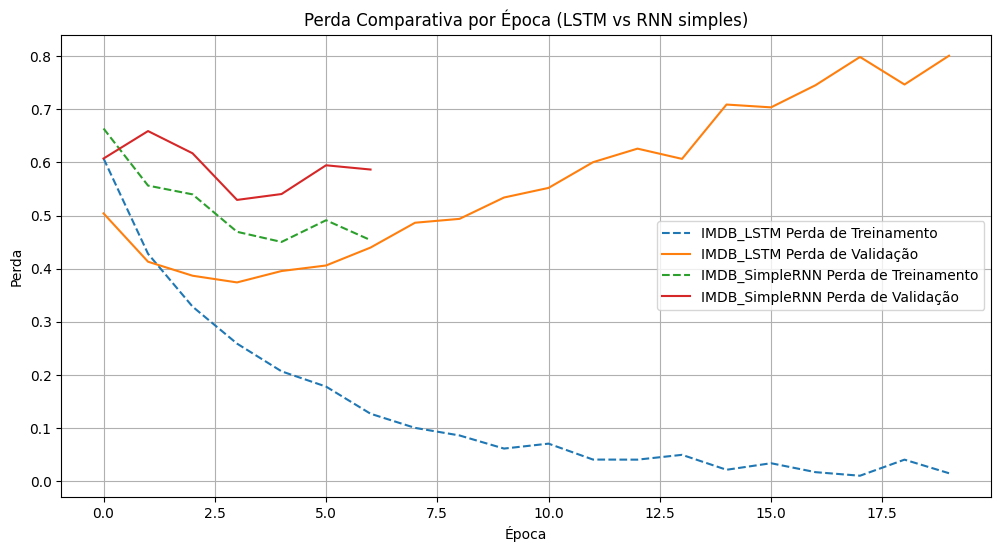

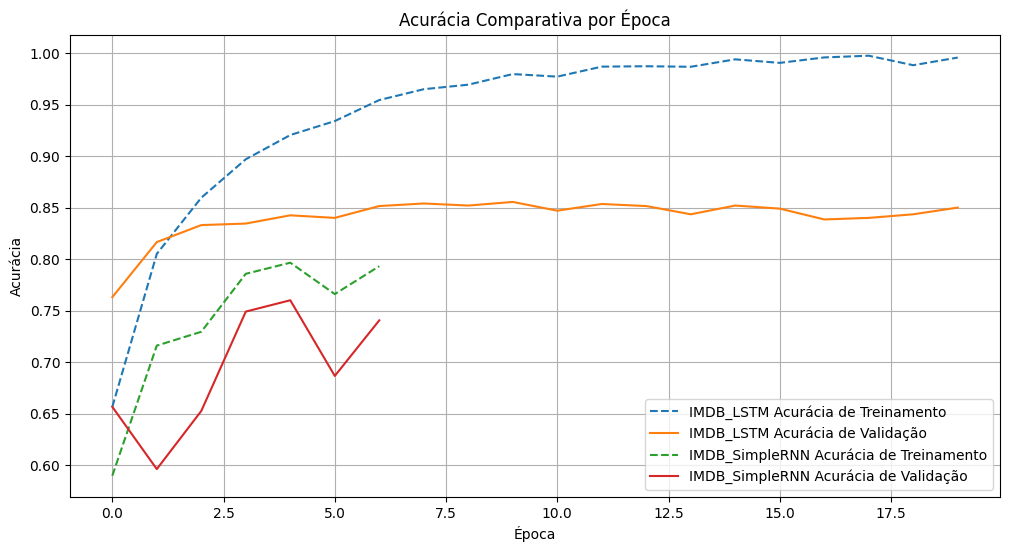

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Função para carregar e processar os logs de treinamento
def load_and_process_logs(log_dir, model_name):
    metrics_path = os.path.join(log_dir, model_name, 'version_0', 'metrics.csv')
    if not os.path.exists(metrics_path):
        print(f"Arquivo de métricas não encontrado para {model_name} em {metrics_path}")
        return None
    metrics_df = pd.read_csv(metrics_path)
    # Aggregate metrics by epoch
    epoch_metrics = metrics_df.groupby('epoch').agg({
        'train_loss': 'mean',
        'valid_loss': 'mean',
        'train_accuracy_epoch': 'mean',
        'valid_accuracy': 'mean'
    }).reset_index()
    epoch_metrics['model'] = model_name
    return epoch_metrics

# Carregar logs para ambos os modelos
lstm_metrics = load_and_process_logs('logs', 'IMDB_LSTM')
rnn_metrics = load_and_process_logs('logs', 'IMDB_SimpleRNN')

# Combinar os dataframes, se ambos foram carregados com sucesso
if lstm_metrics is not None and rnn_metrics is not None:
    combined_metrics = pd.concat([lstm_metrics, rnn_metrics])

    # Plotting the comparative loss
    plt.figure(figsize=(12, 6))
    for model_name in combined_metrics['model'].unique():
        model_data = combined_metrics[combined_metrics['model'] == model_name]
        plt.plot(model_data['epoch'], model_data['train_loss'], linestyle='--', label=f'{model_name} Perda de Treinamento')
        plt.plot(model_data['epoch'], model_data['valid_loss'], label=f'{model_name} Perda de Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.title('Perda Comparativa por Época (LSTM vs RNN simples)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the comparative accuracy
    plt.figure(figsize=(12, 6))
    for model_name in combined_metrics['model'].unique():
        model_data = combined_metrics[combined_metrics['model'] == model_name]
        plt.plot(model_data['epoch'], model_data['train_accuracy_epoch'], linestyle='--', label=f'{model_name} Acurácia de Treinamento')
        plt.plot(model_data['epoch'], model_data['valid_accuracy'], label=f'{model_name} Acurácia de Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Acurácia Comparativa por Época')
    plt.legend()
    plt.grid(True)
    plt.show()
elif lstm_metrics is None:
    print("Não foi possível carregar as métricas da LSTM.")
elif rnn_metrics is None:
     print("Não foi possível carregar as métricas da RNN simples. ")